# Stock Market Prediction
## Ben Welkie & Ishan Jain

In [33]:
import edward as ed
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from edward.models import Categorical, Dirichlet, Uniform, Mixture, Empirical, Normal, InverseGamma, PointMass
import warnings
from hmmlearn.hmm import GaussianHMM
from statsmodels.tsa import ar_model
warnings.filterwarnings('ignore')

## Data
We used the data set of Google's Stock Prices from Aug. 19, 2004 - Jan. 17, 2017. We got this from a Kaggle challenge. Our preprocessing involved calculating the percent increase or percent decrease in stock price for that day. We did this by taking the difference in the closing price between a given day and the previous day's closing price and dividing by yesterday's close price. It is important to convert the raw price into this percent increase or decrease. This is because a stock that increases from 5 to 10 is much more significant increase than a stock that increases from 500 to 505, even though they both increased by 5. In addition, if your emissions values are in dollars instead of percentages then your emission values are very much dependent on where the stock is. Using the example from above, an increase of 5 (so an emission of 5) is much more likely for a stock that is currently at 500 than for a stock that is currently at 5. Therefore, it is very hard to build a hidden markov model that has the raw dollar values as the emission values. Many papers use different formulas to calculate their percent increase/decrease. We've found papers that use the opening price, the highest price for that day, and the closing price that we used. The general consensus is that one isn't better than the other and that they will essentially give you the same results. For more volatile stocks it may be better to use an opening or closing price instead of the daily high since with a volatile stock the daily high may be very far away from the opening or closing price. Included below are two plots. The first plot is the raw closing price of the Google stock data that we used. This is the values from the Kaggle data set that we pulled from the Kaggle challenge website. The second plot is that raw price converted into a percent change that we discussed above. So the formula we used is $$
price_i = \frac{close_i - close_{i-1}}{close_{i-1}}
$$ Where i is a given day, so i-1 is the previous day.

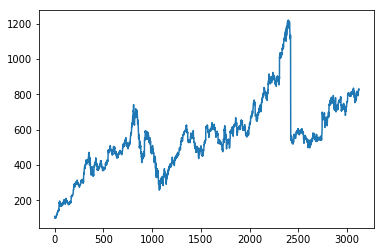

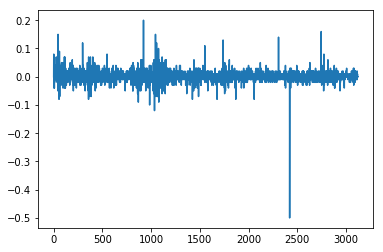

Number of data points: 3125


In [6]:
data = pd.read_csv('/Users/ishan/Downloads/probprog-finalproject-master-2/notebook-example/data/Google.csv')
data = data['Close']
data = data.as_matrix()
plt.plot(data)
plt.show()

## Format data as percent change
for i in reversed(range(1, data.size)):
    data[i] = round((data[i]-data[i-1])/data[i-1], 2)
data[0] = 0

plt.plot(data)
plt.show()
N = data.size
print("Number of data points: {}".format(N))


# Model
## Hidden Markov Model
In a Hidden Markov Model the state is not directly known, but the output (dependent on the state) is known. Each state has a probability distribution over the possible output, so from the HMM we can draw some information about the sequence of states from our sequence of data outputs.
Usually a Hidden Markov Model has a few inferences. One is to infer the probability of an observed sequence. By taking the parameters of the model we can sum over all possible state sequences to get the probability of a particular output. Another is the probability of the latent variables, or given our model parameters and the observed sequence what is the most probable sequence of states. In time series data, HMM's are used for prediction. Using the parameters of the model and the chain of data, the model can predict the next output.
A Hidden Markov Model is a class of discrete-time processes consisting of observations $y_t$ and latent states $x_t \in {1 \dots K}$ generated by a discrete value Markov Chain. We can see that the joint distributions is $$
\begin{align*}
p(x,y) = \pi_0 (x_1) p(y_1|x_1) \Pi_{t=2}^{T} p(x_t|x_{t-1},A)p(y_t|x_t,\phi)
\end{align*}
$$ Where A is the transition matrix defined as  $A_{ij} = P(x_t = j | x_{t-1} = i)$ with $i,j = 1\dots K$ and. $\phi = {\phi_k}_{k=1}^K$ is the emission matrix and $pi_0$ is the initial probabilities. So $\theta = (\pi_0, \phi, A)$ is our HMM parameters.
We use a time length chain of 20. This is equivalent to a month of stock data (5 days out of the week the stock market is open). There isn't a general consensus on the best length to use, and it is most likely dependent on the data you are using. The Google stock data that we are using is a generally stable data set. In other words, the stock isn't very volatile and generally follows a trend. When the stock starts increasing it stays increasing for awhile, when it starts decreasing it stays decreasing for awhile, and when the stock is stationary it stays stationary for awhile. Therefore, by looking at the original data above we can see that a stock stays in a general trend for a minimum of a month (on average), and usually well above that. Therefore, a 20 day chain length seems sufficient. For a more volatile stock that can change it's trend in a shorter time (weekly), it is probably better to choose a shorter chain length so that you can better capture the trends.
For our Hidden Markov Model we chose to use 3 transition states. These transition states correspond to an increasing trend, a decreasing trend, and a stationary trend. We did find one paper that used 6 transition states, which corresponded to the three states we used, but had a mild and a drastic aspect. This meant that they tried to model a drastic increase vs a mild increase, a drastic decrease vs a mild decrease, and a drastic stationary vs a mild stationary. The drastic and mild stationary correspond to how level the line is. Sometimes you can have a trend that is very up and down but on average follows a flat line, but you can also have a trend that follows very closely to a flat line. Therefore, while six states seems to be a valid option we chose to go with the simpler 3 transition state model. In our Hidden Markov Model we decided to discretize our emission values. In the above plot where we calculated the percent change in a daily stock price we rounded the values to the closest percentage (1,2,3,etc.). We printed all the values that appeared in our data set. As you can see, every value is accounted for from -1% up to 1.6%. We concluded that this is sufficient because all of the common values are accounted for (a stock will generally only increase or decrease by 1 percent). For a smaller data set or a more volatile data set you may see that not all values are accounted for. Some common work arounds for this is to include values that aren't accounted for in the data set and assign them a very small emmission probability. Another option is to include them in your data set and assign them values close to their neighbors (so a .5 will get a value close to a .4 or .6).

In [14]:
timelen = 50 
#Chain of stocks for ~1 month
numhidden = 3 
#States are increasing stock, decreasing stock, stable stock
numobs = np.unique(data).size
print(np.sort(np.unique(data)))
print(numobs)

p_init = Categorical(probs=tf.fill([numhidden], 1.0 / numhidden))
#Transition Matrix
Trans = tf.nn.softmax(tf.Variable(tf.zeros([numhidden, numhidden])), dim=0)
#Emission Matrix
Emiss = tf.nn.softmax(tf.Variable(tf.zeros([numobs, numhidden])), dim=0)
#HMM model
x = []
y = []
for t in range(timelen):
    x_tmp = x[-1] if x else p_init
    x_i = Categorical(probs=Trans[:, x_tmp])
    y_i = Categorical(probs=Emiss[:, x_i])
    x.append(x_i)
    y.append(y_i)

[-0.5  -0.12 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01
  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11
  0.12  0.13  0.14  0.15  0.16  0.2 ]
30


# Inference
Perform variational inference first using KL diverence.

In [15]:
qf = [Categorical(probs=tf.nn.softmax(tf.Variable(tf.ones(numhidden)))) for t in range(timelen)]

Run variational inference for 5000 iterations. As we can see, KL doesn't do a good job for estimating the transition and emission matrix.

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    inf_KLqp = ed.KLqp(dict(zip(x, qf)), dict(zip(y, data)))
    inf_KLqp.run(n_iter=5000, n_print=5000/10)
    print(sess.run(Trans))
    print(sess.run(Emiss))

5000/5000 [100%] ██████████████████████████████ Elapsed: 158s | Loss: 0.231
[[ 0.22583939  0.2280381   0.23288229]
 [ 0.22628777  0.22350504  0.22267398]
 [ 0.54787284  0.54845691  0.54444373]]
[[  9.99408841e-01   9.99420404e-01   9.99721229e-01]
 [  2.03866239e-05   1.99805145e-05   9.59853514e-06]
 [  2.03866239e-05   1.99805145e-05   9.59853514e-06]
 [  2.03866239e-05   1.99805145e-05   9.59853514e-06]
 [  2.03866239e-05   1.99805145e-05   9.59853514e-06]
 [  2.03866239e-05   1.99805145e-05   9.59853514e-06]
 [  2.03866239e-05   1.99805145e-05   9.59853514e-06]
 [  2.03866239e-05   1.99805145e-05   9.59853514e-06]
 [  2.03866239e-05   1.99805145e-05   9.59853514e-06]
 [  2.03866239e-05   1.99805145e-05   9.59853514e-06]
 [  2.03866239e-05   1.99805145e-05   9.59853514e-06]
 [  2.03866239e-05   1.99805145e-05   9.59853514e-06]
 [  2.03866239e-05   1.99805145e-05   9.59853514e-06]
 [  2.03866239e-05   1.99805145e-05   9.59853514e-06]
 [  2.03866239e-05   1.99805145e-05   9.59853514e-

# Discussion on inference for HMM
A lot of work in KL has assumed independence or exchangeable data, and for the most part KL isn't tractable to time series data and hidden markov model. KL has notoriously been bad for mixture models and hidden markov models due to the fact that the posterior may be multi-modal. Research has been done in this field to see if inference can be applied to sequential or otherwise non-i.i.d. data. Since time series data is notoriously large most of the research has been in stochastic variational inference and stochastic gradient descent. In some cases, the dependencies in the data must be broken to form the necessary minibatches.
Recent advances in VI have been done using stochastic variational inference. However, this has been mostly studied in independent data sets. A paper out of NIPS is using SVI algorithms to learn the parameters of a HMM with time-dependent data. The problem in applying stochastic optimization arises from dependencies in the chain, which must be broken to form small batches of observations. Their algorithm uses the memory decay of the chain to bound the errors. They claim that this new algorithm will help in applying KL to time-series data.
MCMC has proven successful in learning the parameters of hidden markov models. We attempted to implement MCMC on our hidden markov model by marginalizing out the laten variables. However, we weren't able to get it to work successful. There's a lot of research comparing MCMC vs conventional EM algorithms (forward-backward). We implemented a HMM in Python in hopes of comparing to our MCMC in terms of how close they are, their speed, and other factors. We can compare the Python implementation with our KL inference to see how they compare. We can see that they differ drastically. It can be seen how the parameters from the Python implementation are discrete and multi-modal. This has proven hard for KL inference to approximate. So this is a good example of how KL is not the best method in this situation, even if we weren't able to implement the MCMC method or an improved KL method that has been discussed in the literature.

In [21]:
data = np.column_stack(data)
data = np.transpose(data)
print("fitting to HMM and decoding ...")

# Make an HMM instance and execute fit
print(data.shape[0])
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000).fit(data)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(data)

print("done")

fitting to HMM and decoding ...3125
done


In [22]:
print("Transition matrix")
print(model.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()

Transition matrix
[[ 0.97681469  0.01966133  0.00352398]
 [ 0.07504841  0.90129812  0.02365346]
 [ 0.00097881  0.8718587   0.12716249]]

Means and vars of each hidden state
0th hidden state
mean =  [ 0.00123372]
var =  [ 0.00016077]

1th hidden state
mean =  [-0.00076403]
var =  [ 0.00082099]

2th hidden state
mean =  [ 0.02444816]
var =  [ 0.01673904]



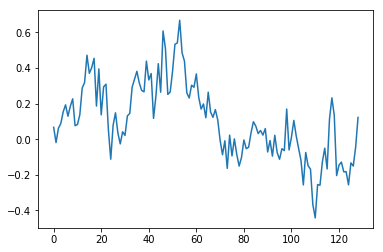

In [27]:
mu = 0.
beta_true = np.array([0.7, 0.25])
noise_obs = 0.1
T = 128
p = 2
#Generate synthetic data
x_true = np.random.randn(T+1)*noise_obs
for t in range(p, T):
    x_true[t] += beta_true.dot(x_true[t-p:t][::-1])
plt.plot(x_true)
plt.show()

In [30]:
mu = Normal(loc=0.0, scale=10.0)
beta = [Normal(loc=0.0, scale=2.0) for i in range(p)]

noise_proc = tf.constant(0.1) 
#InverseGamma(alpha=1.0, beta=1.0)
noise_obs = tf.constant(0.1) 
#InverseGamma(alpha=1.0, beta=1.0)

x = [0] * T
for n in range(p):
    x[n] = Normal(loc=mu, scale=10.0)  # fat prior on x
for n in range(p, T):
    mu_ = mu
    for j in range(p):
        mu_ += beta[j] * x[n-j-1]
    x[n] = Normal(loc=mu_, scale=noise_proc)

In [31]:
print("setting up distributions")
qmu = PointMass(params=tf.Variable(0.))
qbeta = [PointMass(params=tf.Variable(0.)) for i in range(p)]
print("constructing inference object")
vdict = {mu: qmu}
vdict.update({b: qb for b, qb in zip(beta, qbeta)})
inference = ed.MAP(vdict, data={xt: xt_true for xt, xt_true in zip(x, x_true)})
print("running inference")
inference.run()

print("parameter estimates:")
print("beta: ", [qb.value().eval() for qb in qbeta])
print("mu: ", qmu.value().eval())

setting up distributions
constructing inference object
running inference
1000/1000 [100%] ██████████████████████████████ Elapsed: 56s | Loss: -79.123
parameter estimates:
beta:  [0.66550553, 0.20930015]
mu:  0.0125241


In [32]:
print("setting up variational distributions")
qmu = Normal(loc=tf.Variable(0.), scale=tf.nn.softplus(tf.Variable(0.)))
qbeta = [Normal(loc=tf.Variable(0.), scale=tf.nn.softplus(tf.Variable(0.))) for i in range(p)]
print("constructing inference object")
vdict = {mu: qmu}
vdict.update({b: qb for b, qb in zip(beta, qbeta)})
inference_vb = ed.KLqp(vdict, data={xt: xt_true for xt, xt_true in zip(x, x_true)})
print("running inference")
inference_vb.run()

print("parameter estimates:")
for j in range(p):
    print("beta[%d]: " % j, qbeta[j].mean().eval(),)
    #" +- ", qbeta[j].scale().eval())
print("mu: ", qmu.variance().eval())

setting up variational distributions
constructing inference object
running inference
1000/1000 [100%] ██████████████████████████████ Elapsed: 61s | Loss: -70.507
parameter estimates:
beta[0]:  0.649614
beta[1]:  0.200573
mu:  0.000337905


In [34]:
ar2_sm = ar_model.AR(x_true)
res = ar2_sm.fit(maxlag=2, ic=None, trend='c')

print("statsmodels AR(2) params: ", res.params)

statsmodels AR(2) params:  [ 0.0145189   0.6728721   0.19573713]
